# Equity Analyst Agent with Assistants API

### This notebook showcases the capabilities of Azure OpenAI's Assistants API for an Equity Analyst Agent. 

Install the necessary Python packages (openai, matplotlib, tenacity, python-dotenv) for the notebook to function.

In [ ]:
%pip -qqq install openai==1.13.4 matplotlib tenacity python-dotenv azure-identity

Imports the necessary Python modules and classes used in the notebook. Note the openai module is used to interact with the Assistants API.

In [35]:
import os
from azure.identity import DefaultAzureCredential, get_bearer_token_provider
from pathlib import Path
from dotenv import load_dotenv
from openai import AzureOpenAI
from tenacity import RetryError

from azure_ai_util import AzureAIUtils, NotCompletedException

### Initializing Azure OpenAI Client
This cell is crucial for establishing communication with Azure OpenAI services using the most secure and scalable authentication method provided by Azure.

#### Why Managed Identity is Important:
Managed Identity (MI) simplifies Azure service authentication by automatically managing credentials. Using MI, there is no need to store or manage secrets in your application, significantly reducing the risk of credential leakage and enhancing security.

#### How `DefaultAzureCredential` Works:
`DefaultAzureCredential` attempts to find a best-available credential from a series of providers, including managed identity and developer credentials from Azure CLI or Visual Studio. This makes it both flexible and convenient for development and production environments without code changes.

![Azure Identity](https://raw.githubusercontent.com/Azure/azure-sdk-for-net/main/sdk/identity/Azure.Identity/images/mermaidjs/DefaultAzureCredentialAuthFlow.svg)

#### Setup for Azure OpenAI:
1. **Azure Managed Identity**:
   - Ensure that the Azure resource (e.g., Azure OpenAI, Logic Apps, AI Search) running in this notebook is assigned a Managed Identity.
   - Configure the Managed Identity to have access to the Azure OpenAI service by setting appropriate role assignments in Azure RBAC.

- **Keys required in .env File**:
  - `OPENAI_ENDPOINT`: The endpoint URL for the Azure OpenAI service.
  - `OPENAI_MODEL_NAME`: The deployed model name in Azure OpenAI


In [28]:
load_dotenv(".env")
# Get the token provider endpoint from the environment or default to Cognitive Services
token_provider_endpoint = os.getenv("TOKEN_PROVIDER_ENDPOINT", "https://cognitiveservices.azure.com/.default")

# Create a token provider using DefaultAzureCredential
token_provider = get_bearer_token_provider(
    DefaultAzureCredential(), token_provider_endpoint
)

# Get the Azure OpenAI endpoint from the environment
azure_endpoint = os.getenv("OPENAI_ENDPOINT")

if not azure_endpoint:
    raise ValueError("The Azure OpenAI endpoint must be specified in the environment.")

# Initialize the AzureOpenAI client with the token provider
client = AzureOpenAI(
    azure_endpoint=azure_endpoint,
    api_version=os.getenv("OPENAI_API_VERSION", "2024-03-01-preview"),
    #  api_key=os.getenv("OPENAI_API_KEY") # Use this if you have an API key instead of a token (not recommended)
    azure_ad_token_provider=token_provider  # Use token-based authentication (recommended)
)

utils = AzureAIUtils(client)

### Create the assistant with tools and files

![How Assistants work](./images/assistants.png)


The `create_assistant` function creates an assistant with tools and files. The function takes the following parameters:
- `name`: The name of the assistant.
- `instructions`: The system message (or meta prompt) that gives the assistant a persona and context.
- `tools`: A list of tools that the assistant can use to perform tasks. Currently, these are `code_intrepreter` and `retriever`.
- `functions`: Custom functions that the assistant can use to perform tasks. Similar to function calling feature.
- `model`: The name of the model to use for the assistant.

In [29]:
# Fetch the files under the datasets directory
DATASETS = "datasets/"

assistant_files = [utils.upload_file(Path(DATASETS) / file) for file in os.listdir(DATASETS)]
file_ids = [file.id for file in assistant_files]

Create the assistant with tools and files

In [30]:
assistant = client.beta.assistants.create(
    name="Equity Analyst",
    instructions=("You are an equity analyst that performs analysis on the given datasets. "
                  "Use the provided file only."),
    tools=[{"type": "code_interpreter"}],
    file_ids=file_ids,
    model=os.getenv("OPENAI_MODEL_NAME")
)

Create a thread, which represents a conversation. It is recommended to create one thread per user. 

In [31]:
thread = client.beta.threads.create()

Create a thread run

![Run lifecycle](https://cdn.openai.com/API/docs/images/diagram-1.png)

In [32]:
def analyst_assistant(content: str):
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions=f"You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions",
    )

    try:
        run = utils.get_run_lifecycle_status(thread.id, run.id)
        messages = client.beta.threads.messages.list(thread_id=thread.id)
        utils.format_response(messages)
    except RetryError:
        print("Operation failed or timed out after maximum retries.")
    except NotCompletedException:
        print("Operation did not complete in the expected status.")


### Have the assistant perform a DCF valuation

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_vgDWqdmUH2AYHlcvFmHa8oLP', assistant_id='asst_L1pPM89EUBo0QiH2jBSLX7II', cancelled_at=None, completed_at=1713672130, created_at=1713671969, expires_at=None, failed_at=None, file_ids=['assistant-a2CrZIOoD6I8oG2cAvzeIUBc'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1713671970, status='completed', thread_id='thread_dD3M58Kg1YkV6wLOOzMCoHIN', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=Usage(completion_tokens=1191, prompt_t

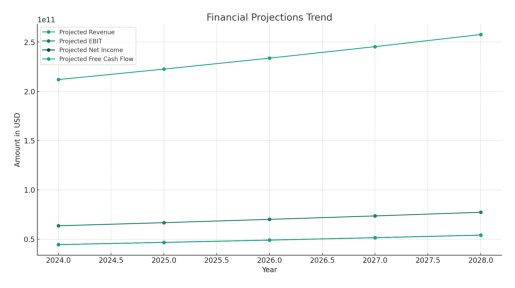

assistant:
The line plot above illustrates the trends in the projected financial metrics over the years. Here are some insights:

1. **Growth Trajectory**: All metrics are showing an upward trend, suggesting optimistic forecasts for revenue, EBIT, net income, and free cash flow. This indicates that the company expects to grow its financial performance in the future.

2. **Consistent Growth Patterns**: The growth rate appears consistent across all metrics. There are no sudden jumps or drops in any of the lines, which suggests a steady growth assumption rather than volatile changes year over year.

3. **Revenue vs Profits**: The revenue line is at the top, which is expected as it is the gross amount before any deductions. The EBIT and net income are always lower due to the subtraction of costs and taxes, respectively. Nonetheless, all profit-related metrics (EBIT, net income, and free cash flow) follow a similar growth pattern, hinting at consistent profit margins over time.

4. **Free C

In [33]:
analyst_assistant("Visualize the data and provide insights on the trends.")

In [9]:
analyst_assistant("Perform a discounted cash flow valuation using the provided dataset, and print the code along with its executed output that was used for this calculation.")

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_LlT56mitw9rQc6o2HPk4mIJJ', assistant_id='asst_EVTjx4hPjZ0IBrEG7oGjtdLS', cancelled_at=None, completed_at=1707617937, created_at=1707617905, expires_at=None, failed_at=None, file_ids=['assistant-6YtpAiT2SdzcLPGqfCd1zCcu'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707617906, status='completed', thread_id='thread_KVRmHgZcBSn2MFL00yH2sHv8', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=None)
user:
Perform a discounted cash flow valuation using the provided dataset, and print the code along with its executed output that was used for this calculation.

assistant:
To 

Run status: queued
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: in_progress
Run status: completed
Run info: Run(id='run_0xCw8vKutDdwkVaaLxfJgVbR', assistant_id='asst_EVTjx4hPjZ0IBrEG7oGjtdLS', cancelled_at=None, completed_at=1707618041, created_at=1707617988, expires_at=None, failed_at=None, file_ids=['assistant-6YtpAiT2SdzcLPGqfCd1zCcu'], instructions="You are a equity analyst who maps out the ask of the user to an equity analyst's task and thinks step by step to analyze, including making use of the tools. Make generic assumptions", last_error=None, metadata={}, model='gpt-4', object='thread.run', required_action=None, started_at=1707617989, status='completed', thread_id='thread_KVRmHgZcBSn2MFL00yH2sHv8', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=None)
user:
Summarize and Visualize this information to someone new to finance and investing.

assistant:
Sure, to explain this to someone new to finance and 

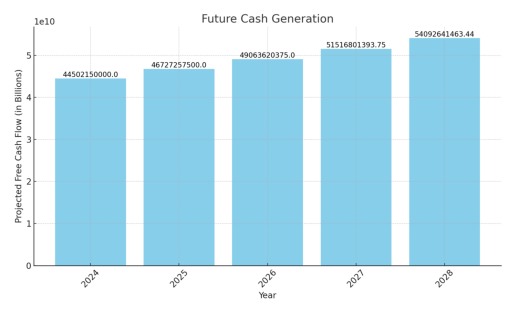

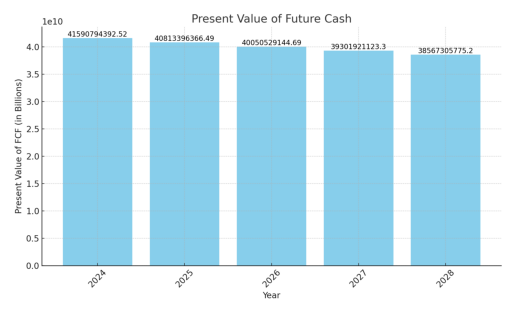

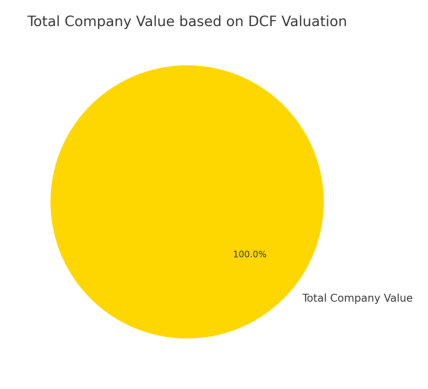

assistant:
Here are visuals that help explain the discounted cash flow (DCF) valuation to someone new to finance and investing:

1. **Future Cash Generation:** This bar chart shows the projected money the company is expected to generate each year in the future, also known as Free Cash Flow (FCF). As you move to the right, you can see the growth in cash generation each year.

2. **Present Value of Future Cash:** The second bar chart adjusts the future cash flows to their value in today's terms, accounting for the concept that money in the future is worth less than money today. These bars appear shorter because of the discount applied.

3. **Total Company Value:** The pie chart represents the total value of the company based on adding up all the present values of future cash flows. It shows what the company is worth today, based on the money it is expected to generate in the future.

The DCF valuation calculated from the provided projections is around $200.32 billion. 

To a new investor

In [10]:
analyst_assistant("Summarize and Visualize this information to someone new to finance and investing.")

### Delete the thread and assistant

In [ ]:
for entity in [(client.beta.assistants, assistant), (client.beta.threads, thread)]:
    entity[0].delete(entity[1].id)

for file in assistant_files:
    client.files.delete(file.id)